# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that
occurred between May 2008 and November 2010,
corresponding to a total of 79354 contacts. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from sklearn.tree import plot_tree

In [5]:
df = pd.read_csv('./data/bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Data Prep Needed

Based on the investigation below, the following steps will need to happen

1. Specific numeric encoding for education - given that there is a hierarchy here which can be rendered as numeric.
2. One hot encoding for several features including job, marital, default, housing, loan, and contact.
3. We will not drop the "unknown" data as those features may not end up in the model.
4. The outcome variable will need to be rendered as numeric 1 for yes, 0 for no.
5. Per the article, 'duration' and any other features which are not known before contact should be removed from the training data.
6. Since the available data is quite unbalanced, we need to either address that in data prep or in model design.

In [7]:
bank = df.copy()
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [8]:
# get the counts of the education column
bank['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [9]:
# look at the value counts for all the non-numeric columns
for col in bank.columns:
    if bank[col].dtype == 'object':
        print(bank[col].value_counts())
        print('\n')

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


contact
cellular     26144
telephone    15044
Name: coun

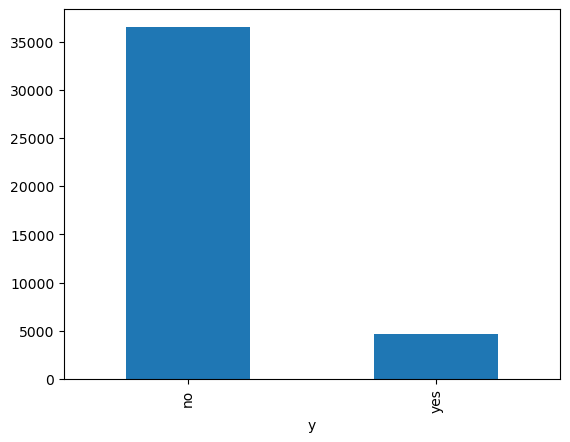

In [11]:
#build a histogram of the y counts
bank['y'].value_counts().plot(kind='bar')
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
Due to internal competition and
current financial crisis, there are huge pressures for
European banks to increase financial assets. 

To solve this
issue, one adopted strategy is offer attractive long-term
deposit applications with good interest rates, in particular
by using directed marketing campaigns.

The primary goal is to increase the 
efficiency of these directed campaigns for long-term deposit
subscriptions by reducing the number of contacts required for each successful outcome.

Our goal is to build a classifier which guides which customers should be contacted with the new offer.  We want to:
1. Maximize the likelihood that a contacted customer will take out a new contract.
2. Contact only those most likely to take out a new contract based on their known attributes.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
# replace the y values with 0 and 1
bank['y'] = bank['y'].replace('no', 0)
bank['y'] = bank['y'].replace('yes', 1)

In [14]:
# subset the data to only include the bank client data
y = bank['y']
X = bank.loc[:, 'age':'loan']

X.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [15]:
# numeric encode the education column
ed_values = {'education': ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']}

# Define a mapping dictionary for education levels
ed_mapping = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    'unknown': -1
}

# Create a new column 'education_encoded' using the mapping
X['education_encoded'] = X['education'].map(ed_mapping)

#replace the unknown values with the mean of the known values in the education_encoded column
mean_ed = round(X[X['education_encoded'] != -1]['education_encoded'].mean())
X['education_encoded'] = X['education_encoded'].replace(-1, mean_ed)

In [16]:
# drop the original education column
X = X.drop('education', axis=1)
X.head()

,age,job,marital,default,housing,loan,education_encoded
0,56,housemaid,married,no,no,no,1
1,57,services,married,unknown,no,no,4
2,37,services,married,no,yes,no,4
3,40,admin.,married,no,no,no,2
4,56,services,married,no,no,yes,4


In [17]:
# one-hot encode the remaining columns
X = pd.get_dummies(X, columns=['job', 'marital', 'default', 'housing', 'loan'])

X.head()

,age,education_encoded,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,1,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,57,4,False,False,False,False,False,False,False,True,...,False,False,True,False,True,False,False,True,False,False
2,37,4,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,True,True,False,False
3,40,2,True,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
4,56,4,False,False,False,False,False,False,False,True,...,False,True,False,False,True,False,False,False,False,True


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [18]:
#separate the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# show the counts of the training and test sets
print('Training Set:')
print(y_train.value_counts())
print('\n')
print('Test Set:')
print(y_test.value_counts())


Training Set:
y
0    29245
1     3705
Name: count, dtype: int64


Test Set:
y
0    7303
1     935
Name: count, dtype: int64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

A: We will use a simple classifier that predicts randomly based on the class distribution in the training set.

In [28]:
def baseline_model(X_test, y_train):
    # determine the distribution of the training set
    counts = y_train.value_counts()

    # calculate the probability of each class
    probs = counts / counts.sum()

    # return a prediction array with the same distribution as the training set
    preds = np.random.choice([0, 1], size=len(X_test), p=probs)
    return preds

baseline_preds = baseline_model(X_test, y_train)


In [78]:
# function to fit the model, calculate and return the accuracy, precision, recall, f1, and roc_auc scores
def calculate_scores(model, X_train, y_train, X_test, y_test, verbose, title):
    # fit the model
    start = time()
    model.fit(X_train, y_train)
    end = time()
    fit_time = end - start

    preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, preds)
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    if verbose:
        print(title)
        print('\tTraining Accuracy: {:.4f}'.format(training_accuracy))
        print('\tTest Accuracy: {:.4f}'.format(accuracy))
        print('\tPrecision: {:.4f}'.format(precision))
        print('\tRecall: {:.4f}'.format(recall))
        print('\tF1: {:.4f}'.format(f1))
        print('\tROC AUC: {:.4f}'.format(roc_auc))
        print('\tFit Time: {:.4f}'.format(fit_time))

    return training_accuracy, accuracy, precision, recall, f1, roc_auc, fit_time

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [83]:
#build a simple logistic regression model
lgr = LogisticRegression(max_iter=10000, class_weight='balanced')
lgr_scores = calculate_scores(lgr, X_train, y_train, X_test, y_test, False, 'Logistic Regression')

# show the accuracy score
print('Accuracy: {:.4f}'.format(lgr_scores[1]))

Accuracy: 0.5840


### Problem 9: Score the Model

What is the accuracy of your model?

A: Accuracy is 0.584

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### Decision Tree

In [84]:
# build a decision tree model
dt_model = DecisionTreeClassifier()
dt_scores = calculate_scores(dt_model, X_train, y_train, X_test, y_test, False, 'Decision Tree')

#### SVM

In [85]:
#build an SVM model
from sklearn.svm import SVC

svm_model = SVC()
svm_scores = calculate_scores(svm_model, X_train, y_train, X_test, y_test, False, 'SVM')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### KNN

In [86]:
# build a KNN model
knn_model = KNeighborsClassifier()
knn_scores = calculate_scores(knn_model, X_train, y_train, X_test, y_test, False, 'KNN')

#### Comparison of Results

In [94]:
#create a dataframe to hold the results
results = pd.DataFrame([lgr_scores, dt_scores, svm_scores, knn_scores],
                        columns=['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Fit Time'],
                        index=['Logistic Regression', 'Decision Tree', 'SVM', 'KNN'])

#set the model column as the index
results['Model'] = results.index

# deindex the dataframe
results = results.reset_index()

print(results[['Model', 'Training Accuracy', 'Test Accuracy', 'Fit Time']].to_string(index=False))


              Model  Training Accuracy  Test Accuracy  Fit Time
Logistic Regression           0.583005       0.584001  0.252017
      Decision Tree           0.914841       0.862709  0.075552
                SVM           0.887557       0.886502  4.819620
                KNN           0.891259       0.871935  0.008635


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Engineering ####
As mentioned above, the datset is unbalanced, so for all of the grid searches, we've specified class_weight where possible.
Second, for models which require it, we've added a StandardScaler step in processing.

#### Hyperparameter Tuning ####

For each model type, we will do a grid search to tune hyperparameters


##### Decision Tree Model #####


In [115]:

# do a grid search to find the best hyperparameters for a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def dt_search(X_train, y_train, verbose=False, scoring='accuracy'):
    if (verbose) :
        print('\nDecision Tree Classifier:\n------------------------')

    tree = DecisionTreeClassifier(random_state=17)

    tree_params = {'max_depth': range(1, 11),
                    'max_features': range(4, 19)}

    tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=verbose, scoring=scoring)

    tree_grid.fit(X_train, y_train)

    if (verbose) :
        # print the best hyperparameters
        print(f'Parameters: {tree_grid.best_params_}')
        print(f'Accuracy: {tree_grid.best_score_}')

    return tree_grid.best_estimator_

##### Logistic Regression 

In [96]:
# do a grid search to find the best hyperparameters for a logistic regression model
from sklearn.model_selection import GridSearchCV

def lgr_search(X_train, y_train, verbose=False, scoring='accuracy'):
    if (verbose) :
        print('\nLogistic Regression:\n-------------------')
        
    lgr = LogisticRegression(max_iter=10000, class_weight='balanced')

    lgr_params = {'lgr__C': [0.01, 0.1, 1, 10, 100],
                  'lgr__solver': ['lbfgs', 'liblinear'],    # Common solvers
                  'lgr__penalty': ['l2']}             # Add other penalties as needed, e.g., 'l1'}

    # set up the pipeline with a standard scaler and the logistic regression model
    lgr_pipe = Pipeline([('scaler', StandardScaler()), ('lgr', lgr)])

    lgr_grid = GridSearchCV(lgr_pipe, lgr_params, cv=5, n_jobs=-1, verbose=verbose, scoring=scoring)

    lgr_grid.fit(X_train, y_train)

    if (verbose) :
        # print the best hyperparameters
        print(f'Parameters:{lgr_grid.best_params_}')
        print(f'Accuracy:{lgr_grid.best_score_}')

    lgr_model = lgr_grid.best_estimator_

    return lgr_model

##### k_Nearest Neighbors

In [99]:
def knn_search(X_train, y_train, verbose=False, scoring='accuracy'):
    if (verbose) :
        print('\nK-Nearest Neighbors:\n-------------------')

    # build a pipeline with a scaler and a KNN model
    knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])

    knn_params = {
        'knn__n_neighbors': range(1, 11),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }

    knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=verbose, scoring=scoring)

    knn_grid.fit(X_train, y_train)

    if (verbose) :
        print(f'Parameters: {knn_grid.best_params_}')
        print(f'Accuracy: {knn_grid.best_score_}')

    return knn_grid.best_estimator_


##### Support Vector Machine

In [112]:
def svm_search(X_train, y_train, verbose=False, scoring='accuracy'):
    if (verbose) :
        print('\nSupport Vector Machine:\n----------------------')

    # build a pipeline with a scaler and an SVM model
    svm_pipe = Pipeline([('scale', StandardScaler()), ('svm', SVC(class_weight='balanced'))])

    svm_params = {
        'svm__C': [0.1, 1],
        'svm__kernel': ['linear', 'rbf'],
        'svm__gamma': ['scale']
    }

    svm_grid = GridSearchCV(svm_pipe, svm_params, cv=5, n_jobs=-1, verbose=verbose, scoring=scoring)

    svm_grid.fit(X_train, y_train)

    if (verbose) :
        print(f'Parameters: {svm_grid.best_params_}')
        print(f'Accuracy: {svm_grid.best_score_}')

    return svm_grid.best_estimator_

##### Running the Grid Searches and Comparing the results

In [103]:
# build a dataframe to store the results

res_dict = {'model': ['k Nearest Neighbors', 'Logistic Regression', 'Decision Tree', 'Support Vector Machine'],
            'train score': [0, 0, 0, 0],
            'accuracy': [0, 0, 0, 0],
            'precision': [0, 0, 0, 0],
            'recall': [0, 0, 0, 0],
            'f1': [0, 0, 0, 0],
            'roc_auc': [0, 0, 0, 0],
            'fit time': [0, 0, 0, 0],
            'seed': [0,0,0,0]}
results_df = pd.DataFrame(res_dict).set_index('model')

In [113]:
def run_grids(X, y, title, n_iter=1, verbose=False, scoring='accuracy'):
    results_df.loc[:, 'train score'] = 0

    for iter in range(n_iter): 
        seed = np.random.randint(1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        knn_model = knn_search(X_train, y_train, verbose, scoring)
        lgr_model = lgr_search(X_train, y_train, verbose, scoring)
        dt_model = dt_search(X_train, y_train, verbose, scoring)
        svm_model = svm_search(X_train, y_train, verbose, scoring)

        models = [knn_model, lgr_model, dt_model, svm_model]

        for i, model in enumerate(models):
            # skip the model if the train score is less than the best result so far
            if (model.score(X_train, y_train) < results_df.loc[results_df.index[i], 'train score']):
                if (verbose): print(f'skipping model: {results_df.index[i]}')
                continue

            if (verbose): print(f'refitting model: {results_df.index[i]}')
                                
            start = time()
            model.fit(X_train, y_train)
            end = time()
            fit_time = end - start

            preds = model.predict(X_test)
            
            results_df.loc[results_df.index[i], 'seed']         = seed
            results_df.loc[results_df.index[i], 'train score']  = float(model.score(X_train, y_train))
            results_df.loc[results_df.index[i], 'fit time']     = fit_time
            results_df.loc[results_df.index[i], 'accuracy']     = float(accuracy_score(y_test, preds))
            results_df.loc[results_df.index[i], 'precision']    = float(precision_score(y_test, preds))
            results_df.loc[results_df.index[i], 'recall']       = float(recall_score(y_test, preds))
            results_df.loc[results_df.index[i], 'f1']           = float(f1_score(y_test, preds))
            results_df.loc[results_df.index[i], 'roc_auc']      = float(roc_auc_score(y_test, preds))
            results_df.loc[results_df.index[i], 'estimator']    = model

        #save the results to a csv file
        results_df.to_csv(f'./data/{title}.{seed}_results.csv')

        if (verbose) :
            print(f'\nResults: Iteration-{iter+1} - Seed={seed}\n--------')
            print(results_df.iloc[:,:-1])

In [126]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning


# # raise an exception if a warning is generated
# warnings.filterwarnings('error', category=UserWarning)
# warnings.resetwarnings()

# Suppress all DeprecationWarnings and FutureWarnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)


In [ ]:


run_grids(X_train, y_train, 'Bank Data', 1, True, 'accuracy')

##### Choosing the performance metric

Since the business goal is to get the most new contracts with the lowest number of contacts, our performance metric should be precision.  This will limit the number of calls and have the highest hit rate for those called.

Note that if there is a tolerance for less efficiency to get more new contracts, this could be tuned further, perhaps by lowering the confidence threshold.

In [117]:
#plot the results
def plot_results(results_df, scoring='accuracy'):
    # plot the results, without the seed column
    results_df.iloc[:, :-1].plot(kind='bar', figsize=(12, 8))
    plt.title(f'Model Performance: {scoring}')
    plt.ylabel('Score')
    #make the y axis labels percentages
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.show()

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_9333/2728022351.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


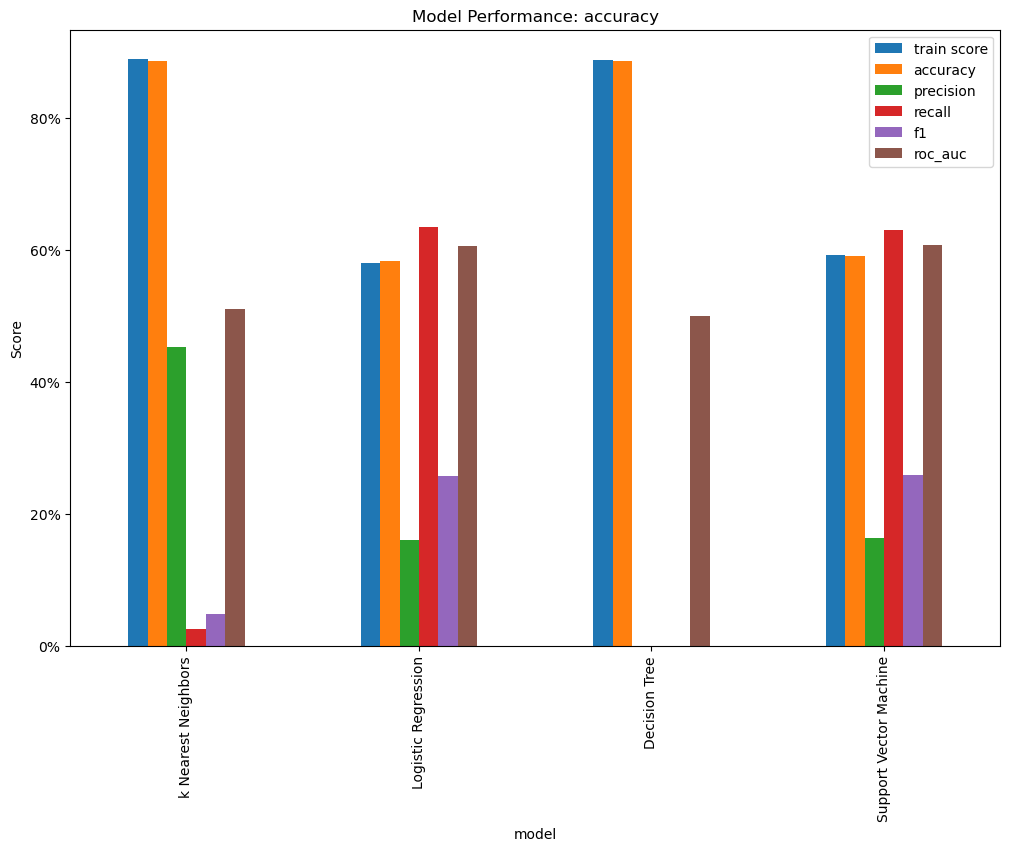

In [118]:

plot_results(results_df.iloc[:,:-2], 'accuracy') 

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrices(models, X, y, titles):
    # Set up a 2x2 grid for displaying confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten the 2D array of axes into a 1D array
    
    for i, (model, title) in enumerate(zip(models, titles)):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred)

        # Plotting the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{title}: Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

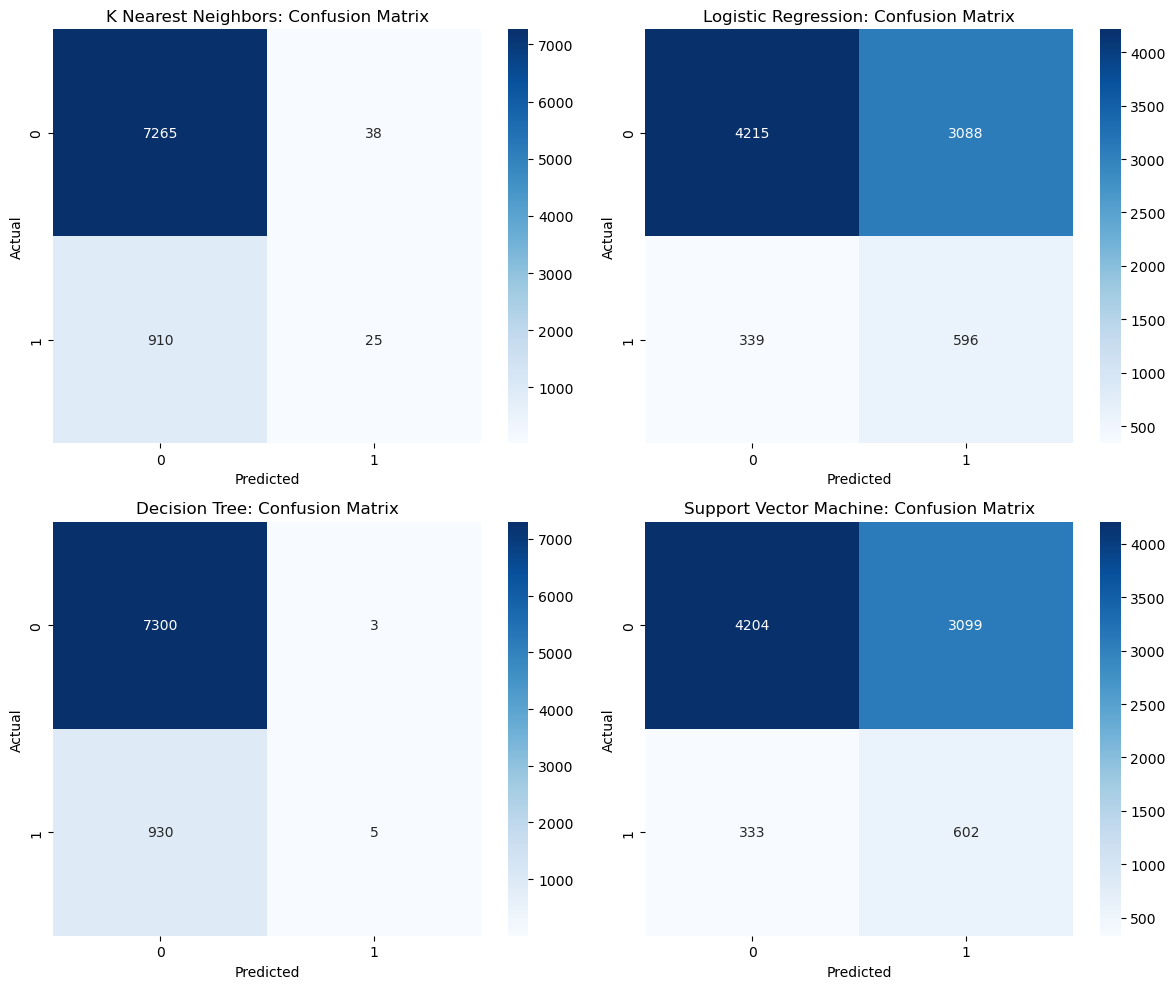

In [121]:

show_confusion_matrices(results_df['estimator'], X_test, y_test, ['K Nearest Neighbors', 'Logistic Regression', 'Decision Tree', 'Support Vector Machine'])



K-Nearest Neighbors:
-------------------
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Parameters: {'knn__n_neighbors': 8, 'knn__p': 1, 'knn__weights': 'uniform'}
Accuracy: 0.5094388164247254

Logistic Regression:
-------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Parameters:{'lgr__C': 1, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Accuracy:0.15898625758338764

Decision Tree Classifier:
------------------------
Fitting 5 folds for each of 150 candidates, totalling 750 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

Parameters: {'max_depth': 4, 'max_features': 10}
Accuracy: 0.6468253968253969

Support Vector Machine:
----------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy: 0.15736668771886958
refitting model: k Nearest Neighbors
refitting model: Logistic Regression
refitting model: Decision Tree
refitting model: Support Vector Machine

Results: Iteration-1 - Seed=455
--------
                        train score  accuracy  precision    recall        f1  \
model                                                                          
k Nearest Neighbors        0.891351  0.881335   0.307692  0.020997  0.039312   
Logistic Regression        0.584939  0.577845   0.158322  0.614173  0.251748   
Decision Tree              0.889150  0.883460   0.428571  0.023622  0.044776   
Support Vector Machine     0.588657  0.581942   0.159316  0.611549  0.252780   

                         roc_auc   fit time  

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_9333/2728022351.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


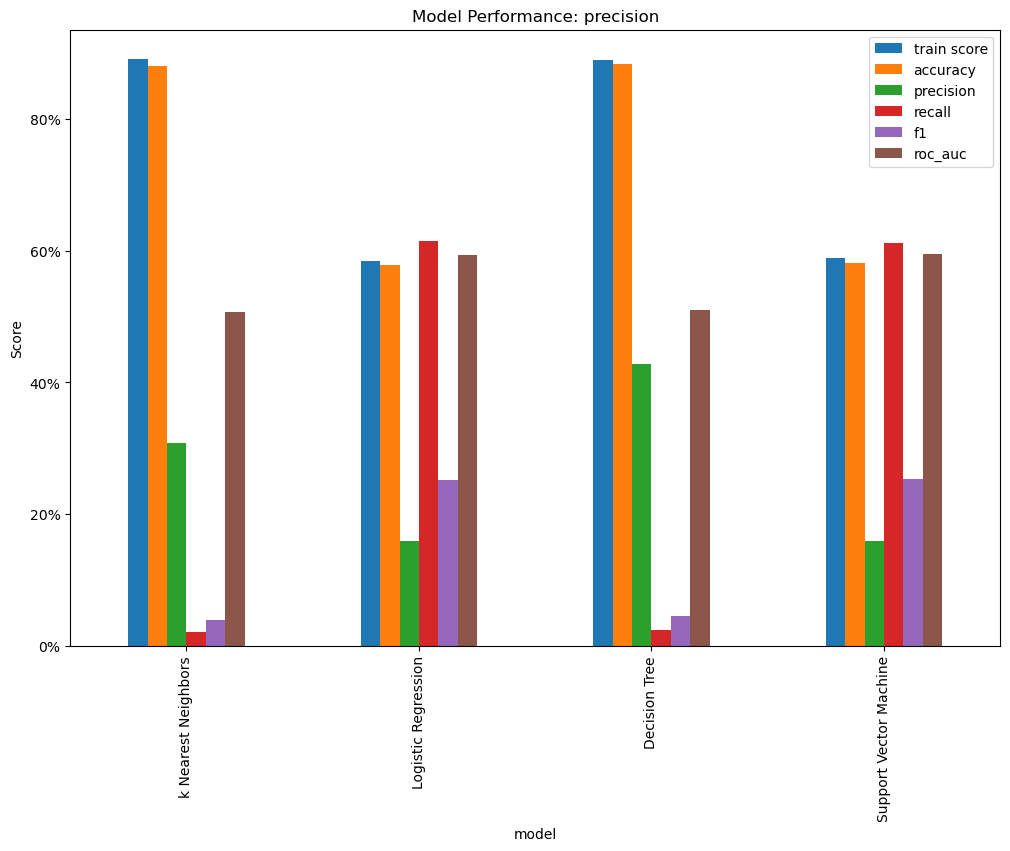

In [128]:
# re run the grid search for precision
run_grids(X_train, y_train, 'Bank Data', 1, True, 'precision')

# plot the results
plot_results(results_df.iloc[:,:-2], 'precision')

#### Looking at resulting feature coefficients, permutation importance, support vector and decision tree


In [129]:
def show_coefficients(model, X, title):
    # if the model is a pipeline, get the model from the last step
    if isinstance(model, Pipeline):
        model = model.steps[-1][1]
        
    # get the coefficients
    coefficients = model.coef_[0]
    indices = np.argsort(np.abs(coefficients))[::-1]

    # plot the absolute values of the coefficients
    plt.figure(figsize=(10, 5))
    plt.title(title + ": Coefficient values")
    plt.bar(range(X.shape[1]), coefficients[indices], align='center')
    plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [130]:
# show the permutation importances
from sklearn.inspection import permutation_importance

def show_permutation_importances(model, X, y, title):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=17, n_jobs=-1)
    importances = result.importances_mean
    indices = np.argsort(np.abs(importances))[::-1]

    # plot the permutation importances
    plt.figure(figsize=(10, 5))
    plt.title(title + ": Permutation importances")
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])

    plt.show()

In [132]:
def show_svm(svm_model, X, title):
    # if the model is a pipeline, get the model from the last step
    if isinstance(svm_model, Pipeline):
        svm_model = svm_model.steps[-1][1]
        
    # if the outcome is linear, show the coefficients
    if (svm_model.kernel == 'linear'):   
        coefficients = svm_model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]

        # plot the coefficients
        plt.figure(figsize=(10, 5))
        plt.title(title + ": Coefficient values")
        plt.bar(range(X.shape[1]), coefficients[indices], align='center')
        plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.show()

    #if the outcome is rbf, show the support vectors
    if (svm_model.kernel == 'rbf'):
        support_vectors = svm_model.support_vectors_

        #plot the support vectors
        plt.figure(figsize=(10, 5))
        plt.title(title + ": Support vectors")
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c='r')
        plt.show()

In [137]:


def show_decision_tree(model, X, title):

    # Create a plot of the decision tree
    plt.figure(figsize=(12, 12))
    plot_tree(model, filled=True, feature_names=X.columns, class_names=['Yes','No'], rounded=True)
    plt.title(title)
    plt.show()

    # get the feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # plot the feature importances, ordered
    plt.figure(figsize=(12, 8))
    plt.title(title + ": Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

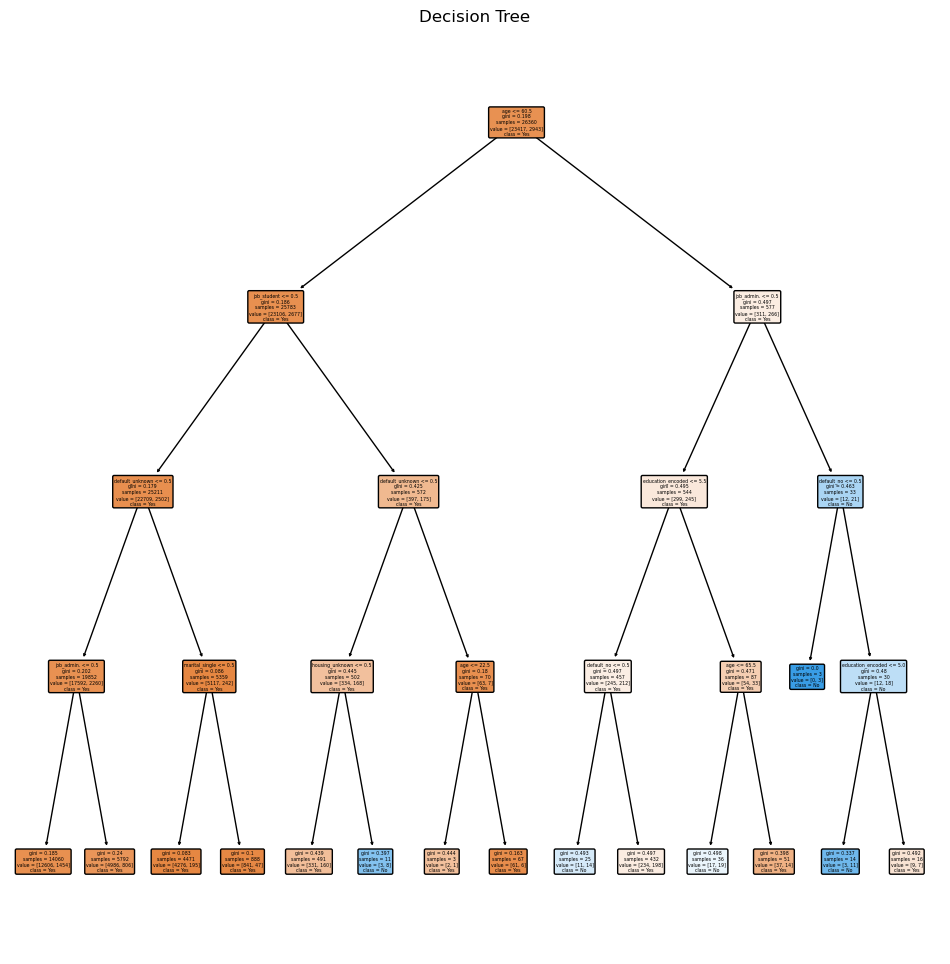

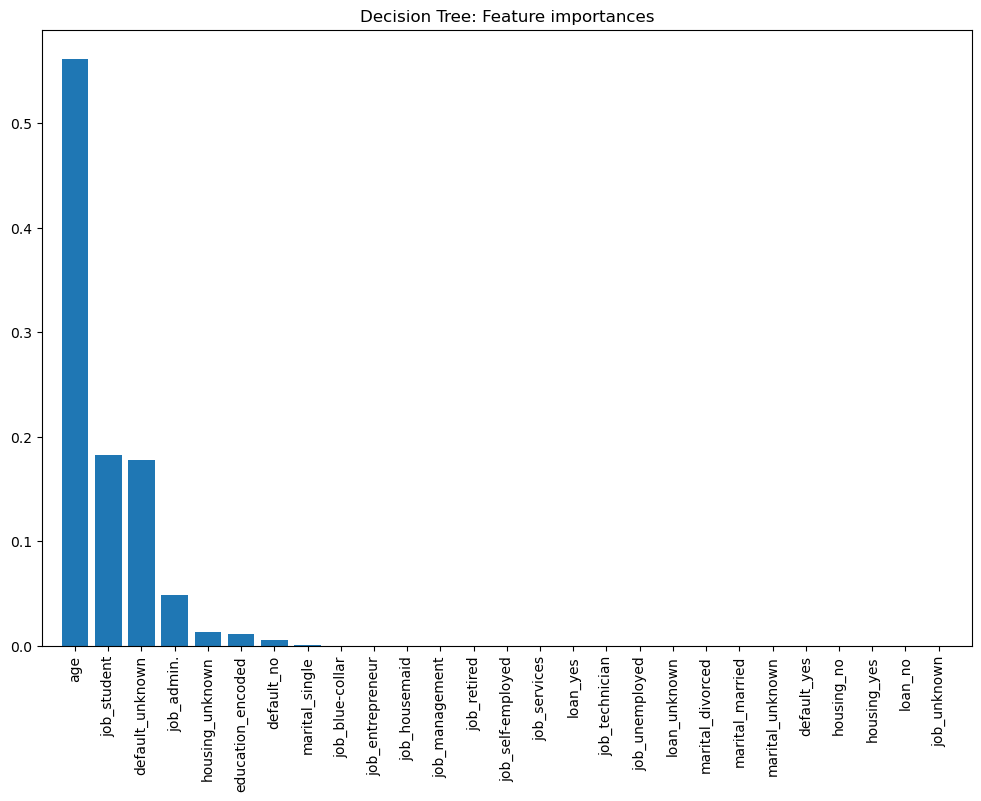

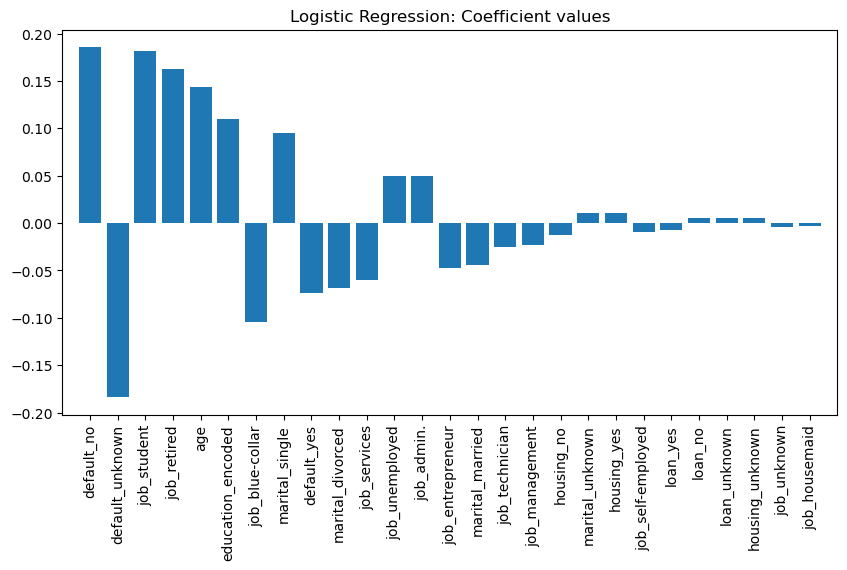

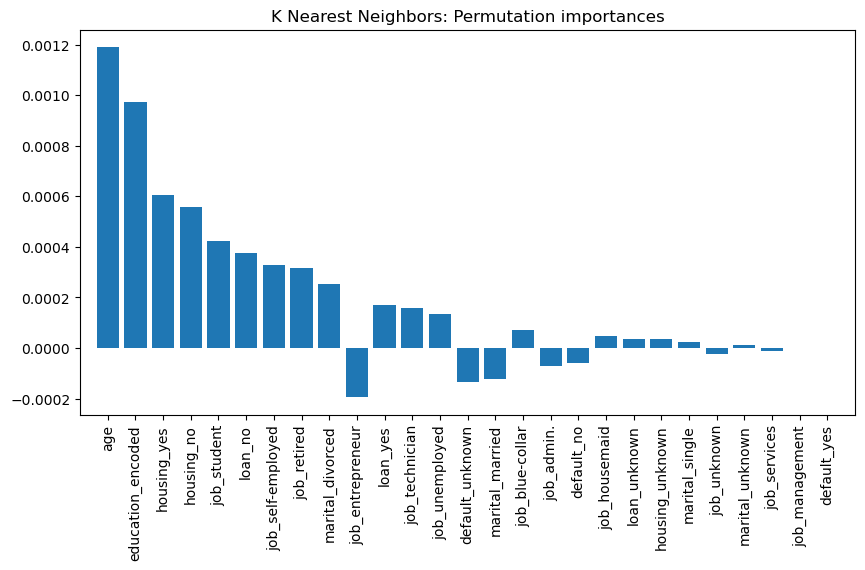

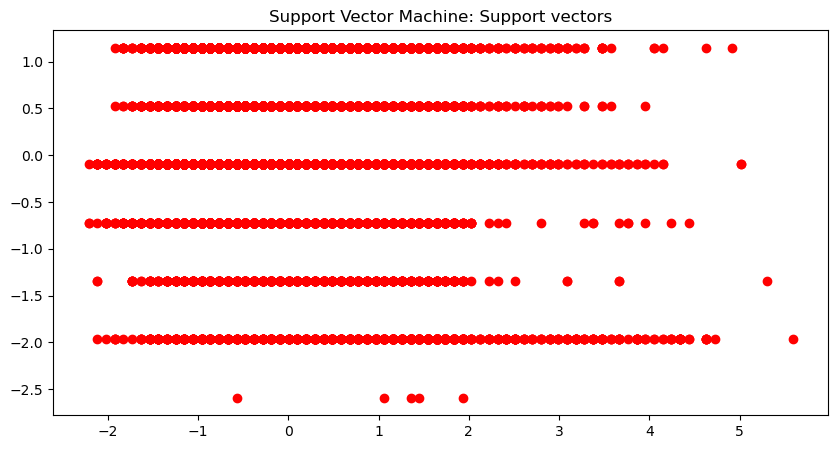

In [138]:

# show the descriptive results for each winning model
dt_model = results_df.loc['Decision Tree', 'estimator']
lgr_model = results_df.loc['Logistic Regression', 'estimator']
knn_model = results_df.loc['k Nearest Neighbors', 'estimator']
svm_model = results_df.loc['Support Vector Machine', 'estimator']

show_decision_tree(dt_model, X, 'Decision Tree')
show_coefficients(lgr_model, X, 'Logistic Regression')
show_permutation_importances(knn_model, X_test, y_test, 'K Nearest Neighbors')
show_svm(svm_model, X, 'Support Vector Machine')

### Working to get more positives

All of our models are under-representing positives in their predictions.  The code below assessed the value of combining models using a simple boolean or, and found that the resulting improvement in precision (from 40% for decision tree to 42% for decision tree or knn) was not worth the added complexity

In [139]:
knn_preds = knn_model.predict(X_test)
lgr_preds = lgr_model.predict(X_test)
dt_preds = dt_model.predict(X_test)
svm_preds = svm_model.predict(X_test)

knn_or_dt   = knn_preds | dt_preds
knn_or_lgr  = knn_preds | lgr_preds
knn_or_svm  = knn_preds | svm_preds
dt_or_lgr   = dt_preds | lgr_preds
dt_or_svm   = dt_preds | svm_preds
lgr_or_svm  = lgr_preds | svm_preds
all         = knn_preds | lgr_preds | dt_preds | svm_preds

In [140]:
# build a dataframe to store the results
res_dict = {'name': ['k Nearest Neighbors or Decision Tree', 'k Nearest Neighbors or Logistic Regression', 'k Nearest Neighbors or Support Vector Machine',
                      'Decision Tree or Logistic Regression', 'Decision Tree or Support Vector Machine', 'Logistic Regression or Support Vector Machine', 'All'],
            'accuracy': [0, 0, 0, 0, 0, 0, 0],
            'precision': [0, 0, 0, 0, 0, 0, 0],
            'recall': [0, 0, 0, 0, 0, 0, 0],
            'f1': [0, 0, 0, 0, 0, 0, 0],
            'roc_auc': [0, 0, 0, 0, 0, 0, 0],
            'preds': [knn_or_dt, knn_or_lgr, knn_or_svm, dt_or_lgr, dt_or_svm, lgr_or_svm, all]}
hybrids_df = pd.DataFrame(res_dict).set_index('name')

# calculate the results for a model
def load_scores(df, i, y_test):
    preds = df.loc[i, 'preds']
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f'{i}: TN {tn}, FN {fn}, FP {fp}, TP {tp}')
    df.loc[i, 'accuracy'] = accuracy_score(y_test, preds)
    df.loc[i, 'precision'] = precision_score(y_test, preds)
    df.loc[i, 'recall'] = recall_score(y_test, preds)
    df.loc[i, 'f1'] = f1_score(y_test, preds)
    df.loc[i, 'roc_auc'] = roc_auc_score(y_test, preds)
    df.loc[i, 'contacts'] = tp+fp

In [142]:

for i in hybrids_df.index:
    load_scores(hybrids_df, i, y_test)

hybrids_df.iloc[:,:-2]

k Nearest Neighbors or Decision Tree: TN 7249, FN 895, FP 54, TP 40
k Nearest Neighbors or Logistic Regression: TN 4259, FN 335, FP 3044, TP 600
k Nearest Neighbors or Support Vector Machine: TN 4207, FN 336, FP 3096, TP 599
Decision Tree or Logistic Regression: TN 4259, FN 333, FP 3044, TP 602
Decision Tree or Support Vector Machine: TN 4201, FN 334, FP 3102, TP 601
Logistic Regression or Support Vector Machine: TN 3768, FN 269, FP 3535, TP 666
All: TN 3767, FN 267, FP 3536, TP 668


,accuracy,precision,recall,f1,roc_auc
name,,,,,
k Nearest Neighbors or Decision Tree,0.884802,0.425532,0.042781,0.077745,0.517693
k Nearest Neighbors or Logistic Regression,0.589828,0.164654,0.641711,0.262066,0.612448
k Nearest Neighbors or Support Vector Machine,0.583394,0.162111,0.640642,0.258747,0.608353
Decision Tree or Logistic Regression,0.590070,0.165112,0.643850,0.262825,0.613518
Decision Tree or Support Vector Machine,0.582908,0.162301,0.642781,0.259163,0.609012
Logistic Regression or Support Vector Machine,0.538237,0.158534,0.712299,0.259346,0.614126
All,0.538359,0.158896,0.714439,0.259973,0.615127


##### Questions